## BlackSheep Cookbook Exploration

The Black Sheep Analysis allows researchers to find trends in abnormal protein enrichment among patients in CPTAC datasets. In this Cookbook, we will go through the steps needed to perform a full Black Sheep Analysis.

### Step 1a: Import Dependencies
First, import the necessary dependencies and load cptac data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cptac
import binarization_functions as bf
import blackSheepCPTACmoduleCopy as blsh
import gseapy as gp
en = cptac.Endometrial()

Welcome to cptac, a python package for disseminating cancer
proteogenomics data. To view available datasets, enter
'cptac.list_data()'. Extensive tutorials are available at
https://github.com/PayneLab/cptac/tree/master/doc

******
Version: 0.4.5
******
Checking that data files are up-to-date...
100% [..................................................................................] 649 / 649
Data check complete.
endometrial data version: 2.1

Loading acetylproteomics data...
Loading clinical data...
Loading CNA data...
Loading definitions data...
Loading miRNA data...
Loading phosphoproteomics_gene data...
Loading phosphoproteomics_site data...
Loading proteomics data...
Loading somatic data...
Loading somatic_binary data...
Loading transcriptomics_circular data...
Loading transcriptomics_linear data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utiliz

## Step 1b: Load Data and Choose Omics Table

In [2]:
proteomics = en.get_proteomics()
mRNA = en.get_transcriptomics()
phospho = en.get_phosphoproteomics()
clinical = en.get_clinical()

In [3]:
#Append Genomics_subtype and MSI_status to en.get_clinical()
df= en.get_derived_molecular()
clinical['MSI_status'] = df['MSI_status']
clinical['Genomics_subtype'] = df['Genomics_subtype']

## Step 2: Determine what attributes you would like to A/B test. 
For this analysis, we will iteratively go through the various columns in the clinical dataset, to determine if any of them have trends within them for protein enrichment.

In [4]:
#Create a copy of the original Clinical DataFrame and drop irrelevant columns.
annotations = pd.DataFrame(clinical.copy())
annotations = annotations.drop(['Patient_ID', 
                                'Treatment_naive', 
                                'Tumor_purity', 
                                'Gender', 
                                'Tumor_Site_Other'], axis=1)

## Step 2a: Binarize column values

In [5]:
tumor_map = {'Tumor':'Normal_Tumor', 
             'Adjacent_normal':'Other_tumor', 
             'Enriched_normal':'Other_tumor', 
             'Myometrium_normal':'Other_tumor'}

annotations['Proteomics_Tumor_Normal'] = bf.binarizeCategorical(clinical, 
                                                                'Proteomics_Tumor_Normal', 
                                                                tumor_map)

country_map = {'United States':'US', 
               'Ukraine':'Other', 
               'Other_specify':'Other', 
               'Poland':'Other'}

annotations['Country'] = bf.binarizeCategorical(clinical, 
                                                'Country', 
                                                country_map)

annotations['BMI'] = bf.binarizeRange(clinical, 'BMI', 18, 25, 
                                      'Healthy', 'Unhealthy')

annotations['Age'] = bf.binarizeCutOff(clinical, 'Age', 
                                       60.0, 'Old', 'Young')
FIGO_map = {'FIGO grade 1':'Low_grade', 
            'FIGO grade 2':'High_grade', 
            'FIGO grade 3':'High_grade'}

annotations['Histologic_Grade_FIGO'] = bf.binarizeCategorical(clinical, 
                                                              'Histologic_Grade_FIGO', 
                                                              FIGO_map)
Myo_map = {'under 50 %':'under_50%', 
           '50 % or more': '50%_or_more', 
           'Not identified': 'under_50%'}

annotations['Myometrial_invasion_Specify'] = bf.binarizeCategorical(clinical, 
                                                                    'Myometrial_invasion_Specify', 
                                                                    Myo_map)
path_tumor_map = {'pT1a (FIGO IA)':'Not_FIGO_III', 
            'pT1b (FIGO IB)':'Not_FIGO_III', 
            'pT2 (FIGO II)':'Not_FIGO_III', 
            'pT1 (FIGO I)':'Not_FIGO_III', 
            'pT3a (FIGO IIIA)':'FIGO_III', 
            'pT3b (FIGO IIIB)':'FIGO_III'}

annotations['Path_Stage_Primary_Tumor-pT'] = bf.binarizeCategorical(clinical, 
                                                                    'Path_Stage_Primary_Tumor-pT', 
                                                                    path_tumor_map)

path_lymph_map = {'pN0':'Not_FIGO_III', 
                  'pNX':'Not_FIGO_III', 
                  'pN1 (FIGO IIIC1)':'FIGO_III', 
                  'pN2 (FIGO IIIC2)':'FIGO_III'}

annotations['Path_Stage_Reg_Lymph_Nodes-pN'] = bf.binarizeCategorical(clinical, 
                                                                      'Path_Stage_Reg_Lymph_Nodes-pN', 
                                                                      path_lymph_map)
clin_stage_map = {'cM0':'cM0_or_cM1', 
                  'cM1':'cM0_or_cM1', 
                  'Staging Incomplete':'Staging_Incomplete'}

annotations['Clin_Stage_Dist_Mets-cM'] = bf.binarizeCategorical(clinical, 
                                                                'Clin_Stage_Dist_Mets-cM', 
                                                                clin_stage_map)

path_stage_map = {'Staging Incomplete': 'No_distant_metastasis', 
                  'No pathologic evidence of distant metastasis':'No_distant_metastasis', 
                  'pM1':'Distant_Metastasis'}

annotations['Path_Stage_Dist_Mets-pM'] = bf.binarizeCategorical(clinical, 
                                                                'Path_Stage_Dist_Mets-pM', 
                                                                path_stage_map)

tumor_stage_map = {'Stage I':'Stage_I_or_II', 
                   'Stage II':'Stage_I_or_II', 
                   'Stage III':'Stage_III_or_IV', 
                   'Stage IV':'Stage_III_or_IV'}

annotations['tumor_Stage-Pathological'] = bf.binarizeCategorical(clinical, 
                                                               'tumor_Stage-Pathological', 
                                                               tumor_stage_map)
FIGO_stage_map = {'IA':'I_or_II', 
                  'IB':'I_or_II', 
                  'II':'I_or_II', 
                  'IIIA':'III_or_IV', 
                  'IIIC1':'III_or_IV', 
                  'IVB':'III_or_IV', 
                  'IIIC2':'III_or_IV', 
                  'IIIB':'III_or_IV'}

annotations['FIGO_stage'] = bf.binarizeCategorical(clinical, 
                                                   'FIGO_stage', 
                                                   FIGO_stage_map)
diabetes_map = {'No':'No', 
                'Yes':'Yes', 
                'Unknown':'No'}

annotations['Diabetes'] = bf.binarizeCategorical(clinical, 
                                                 'Diabetes', 
                                                 diabetes_map)

race_map = {'White':'White', 
            'Black or African American':'Not_White', 
            'Asian':'Not_White', 
            'Not Reported':'Not_White'}

annotations['Race'] = bf.binarizeCategorical(clinical, 
                                             'Race', 
                                             race_map)

ethnicity_map = {'Not-Hispanic or Latino':'Not_Hispanic', 
                 'Not reported':'Not_Hispanic', 
                 'Hispanic or Latino':'Hispanic'}

annotations['Ethnicity'] = bf.binarizeCategorical(clinical, 
                                                  'Ethnicity', 
                                                  ethnicity_map)

tumor_site_map = {'Other, specify':'Not_Anterior', 
                  'Anterior endometrium':'Anterior', 
                  'Posterior endometrium':'Not_Anterior'}

annotations['Tumor_Site'] = bf.binarizeCategorical(clinical, 
                                                   'Tumor_Site', 
                                                   tumor_site_map)

annotations['Tumor_Size_cm'] = bf.binarizeCutOff(clinical, 
                                                'Tumor_Size_cm', 4.0, 
                                                'Large_tumor', 
                                                'Small_tumor')

num_pregnancies_map = {2:'Less_than_3', 
                       1:'Less_than_3', 
                       'None':'Less_than_3', 
                       None:'Less_than_3', 
                       3:'3_or_more', 
                       '4 or more':'3_or_more'}

annotations['Num_full_term_pregnancies'] = bf.binarizeCategorical(clinical, 
                                                                  'Num_full_term_pregnancies', 
                                                                  num_pregnancies_map)

genomics_map = {'MSI-H':'MSI-H', 
                'CNV_low':'Other_subtype', 
                'CNV_high':'Other_subtype', 
                'POLE':'Other_subtype'}

annotations['Genomics_subtype'] = bf.binarizeCategorical(clinical, 
                                                         'Genomics_subtype', 
                                                         genomics_map)

## Step 3: Perform outliers analysis

In [6]:
outliers_prot = blsh.make_outliers_table(proteomics, iqrs=1.5, 
                                         up_or_down='up', 
                                         aggregate=False, 
                                         frac_table=False)

outliers_phospho = blsh.make_outliers_table(phospho, iqrs=1.5,
                                            up_or_down='up', 
                                            aggregate=False, 
                                            frac_table=False)

C:\Users\Cindy\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


## Step 4: Wrap your A/B test into the outliers analysis, and create a table

In [7]:
results_prot = blsh.compare_groups_outliers(outliers_prot, 
                                            annotations)

results_phospho = blsh.compare_groups_outliers(outliers_phospho, 
                                               annotations)

No rows had outliers in at least 0.3 of Proteomics_Tumor_Normal Normal_Tumor samples
Testing 14 rows for enrichment in Proteomics_Tumor_Normal Other_tumor samples
No rows had outliers in at least 0.3 of Country Other samples
No rows had outliers in at least 0.3 of Country US samples
Testing 2 rows for enrichment in Histologic_Grade_FIGO High_grade samples
Testing 1 rows for enrichment in Histologic_Grade_FIGO Low_grade samples
No rows had outliers in at least 0.3 of Myometrial_invasion_Specify under_50% samples
Testing 7 rows for enrichment in Myometrial_invasion_Specify 50%_or_more samples
No rows had outliers in at least 0.3 of Histologic_type Endometrioid samples
Testing 626 rows for enrichment in Histologic_type Serous samples
No rows had outliers in at least 0.3 of Path_Stage_Primary_Tumor-pT Not_FIGO_III samples
Testing 241 rows for enrichment in Path_Stage_Primary_Tumor-pT FIGO_III samples
No rows had outliers in at least 0.3 of Path_Stage_Reg_Lymph_Nodes-pN Not_FIGO_III samples

Many of the output values from compare_group_outliers are NaN, so here we will get rid of the NaN values for visualization purposes.

In [8]:
results_prot = results_prot.dropna(axis=0, how='all')
results_phospho = results_phospho.dropna(axis=0, how='all')

## Step 5: Visualize these enrichments

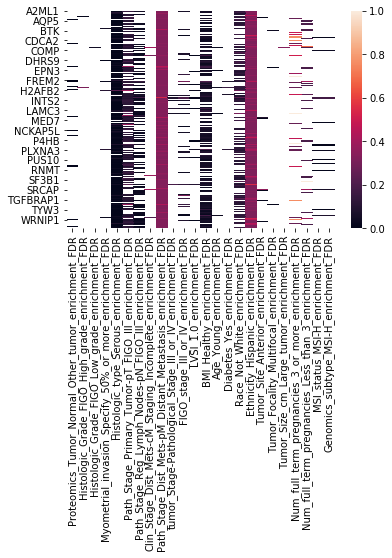

In [9]:
sns.heatmap(results_prot)
plt.show()

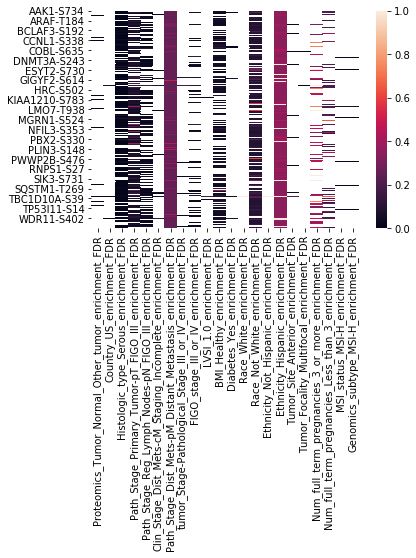

In [10]:
sns.heatmap(results_phospho)
plt.show()

## Step 6: Determine significant enrichments, and link with cancer drug database.

In [11]:
print("TESTING FOR PROTEOMICS:")
sig_cols = []
for col in results_prot.columns:
    sig_col = bf.significantEnrichments(results_prot, col, 0.025)
    if sig_col is not None:
        gene_name_list = list(sig_col.index)
        enrichment = gp.enrichr(gene_list = gene_name_list, 
                                description='ARID1A_Impacted', 
                                gene_sets='KEGG_2019_Human', 
                                outdir='test/enrichr_kegg',
                                cutoff=.5)
    
        print(enrichment.res2d)
    else:
        continue

#print("TESTING FOR PHOSPHOPROTEOMICS:")
#for col in results_phospho:
#    sig_col = bf.significantEnrichments(results_phospho, col, 0.01)
#    sig_col 

TESTING FOR PROTEOMICS:
14 significant protein enrichments in Proteomics_Tumor_Normal_Other_tumor

           Gene_set                                             Term Overlap  \
0   KEGG_2019_Human                    Glycosaminoglycan degradation    1/19   
1   KEGG_2019_Human                                      Ferroptosis    1/40   
2   KEGG_2019_Human                            TNF signaling pathway   1/110   
3   KEGG_2019_Human             Toll-like receptor signaling pathway   1/104   
4   KEGG_2019_Human            Regulation of lipolysis in adipocytes    1/55   
5   KEGG_2019_Human                                      Endocytosis   2/244   
6   KEGG_2019_Human                                      Necroptosis   1/162   
7   KEGG_2019_Human                       Osteoclast differentiation   1/127   
8   KEGG_2019_Human                T cell receptor signaling pathway   1/101   
9   KEGG_2019_Human                           GnRH signaling pathway    1/93   
10  KEGG_2019_Human  

[192 rows x 10 columns]
26 significant protein enrichments in Path_Stage_Reg_Lymph_Nodes-pN_FIGO_III

           Gene_set                                               Term  \
0   KEGG_2019_Human                            African trypanosomiasis   
1   KEGG_2019_Human                 Cysteine and methionine metabolism   
2   KEGG_2019_Human                              TNF signaling pathway   
3   KEGG_2019_Human                       NF-kappa B signaling pathway   
4   KEGG_2019_Human                                        Spliceosome   
5   KEGG_2019_Human                                            Malaria   
6   KEGG_2019_Human                      Inositol phosphate metabolism   
7   KEGG_2019_Human              Phosphatidylinositol signaling system   
8   KEGG_2019_Human             Fluid shear stress and atherosclerosis   
9   KEGG_2019_Human  AGE-RAGE signaling pathway in diabetic complic...   
10  KEGG_2019_Human                     Cell adhesion molecules (CAMs)   
11  KEGG_2

2     0.046102              0.046102   -1.232117        4.454585  EPHA7  
5 significant protein enrichments in Tumor_Site_Anterior

          Gene_set                   Term Overlap   P-value  Adjusted P-value  \
0  KEGG_2019_Human  Fatty acid elongation    1/27  0.006732          0.006732   
1  KEGG_2019_Human    Folate biosynthesis    1/26  0.006484          0.006732   
2  KEGG_2019_Human    Thiamine metabolism    1/15  0.003745          0.006732   
3  KEGG_2019_Human         Protein export    1/23  0.005737          0.006732   

   Old P-value  Old Adjusted P-value    Z-score  Combined Score  Genes  
0     0.010725              0.010725 -51.116803      255.625573   MECR  
1     0.010343              0.010725 -40.877606      205.959909   ALPG  
2     0.006138              0.010725 -18.073696      100.984959   ALPG  
3     0.009198              0.010725 -12.009321       61.977171  SRP19  
2 significant protein enrichments in Tumor_Focality_Multifocal

          Gene_set           Term

In [28]:
column = 'BMI_Healthy_enrichment_FDR'
sig_results_BMI_Healthy = bf.significantEnrichments(results_prot, column, 0.025)
gene_name_list = list(sig_results_BMI_Healthy.index)

7 significant protein enrichments in BMI_Healthy



In [20]:
column = 'Proteomics_Tumor_Normal_Other_tumor_enrichment_FDR'
sig_results_Serous = bf.significantEnrichments(results_prot, column)
gene_name_list = list(sig_results_Serous)

14 significant protein enrichments in Proteomics_Tumor_Normal_Other_tumor



In [24]:
column = 'Path_Stage_Reg_Lymph_Nodes-pN_FIGO_III_enrichment_FDR'
sig_results_FIGO_III = bf.significantEnrichments(results_prot, column)
gene_name_list = list(sig_results_FIGO_III)

118 significant protein enrichments in Path_Stage_Reg_Lymph_Nodes-pN_FIGO_III



In [26]:
column = 'FIGO_stage_III_or_IV_enrichment_FDR'
sig_results_FIGO_III_or_IV = bf.significantEnrichments(results_prot, column)
gene_name_list = list(sig_results_FIGO_III_or_IV)

5 significant protein enrichments in FIGO_stage_III_or_IV



In [30]:
column = 'Proteomics_Tumor_Normal_Other_tumor_enrichment_FDR'
sig_results_Other_tumor = bf.significantEnrichments(results_prot, column)
gene_name_list = list(sig_results_Other_tumor)

14 significant protein enrichments in Proteomics_Tumor_Normal_Other_tumor



In [31]:
'''
-Gene-set Enrichment Analysis on significant genes for BMI-Healthy Patients

-Need to double-check with Sam/Brittany to see if I did this right, but it 
appears to be correct

-Only the genes from BMI_Healty have enrich terms, but the other clinical 
attributes do not. Why is that? Am I doing this wrong? Even for Histologic
Type Serous, that has 538 significant proteins, there were no enrich terms
after this analysis. How could that be?
'''
enrichment = gp.enrichr(gene_list = gene_name_list, 
                        description='ARID1A_Impacted', 
                        gene_sets='KEGG_2019_Human', 
                        outdir='test/enrichr_kegg',
                        cutoff=.5)
    
print(enrichment.res2d)

2019-06-17 11:14:23,440 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.5


Empty DataFrame
Columns: [Gene_set, Term, Overlap, P-value, Adjusted P-value, Old P-value, Old Adjusted P-value, Z-score, Combined Score, Genes]
Index: []


In [39]:
gp.get_library_name()

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlex_2017',
 'CORUM',
 'Cancer_Cell_Line_Encyclopedia',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
 'Disease_Perturbations_from_GEO_down',
 'Disease_Perturbations_from_GEO_up',
 'Disease_Signatures_from_GEO_down_2014',
 'Disease_Signatures_from_GEO_up_2014',
 'DrugMatrix',
 'Drug_Perturbations_from_GEO_2014',
 'Drug_Perturbations_from_GEO_down',
 'Drug_Perturbations_from_GEO_up',
 'ENCODE_Histone_Modifications_2013',
 'ENCODE_Histon

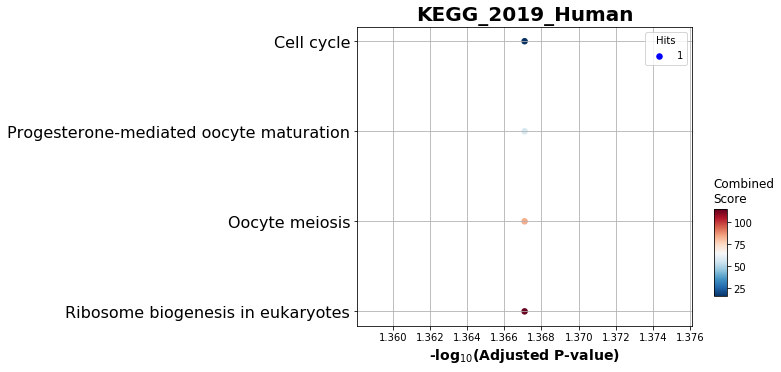

In [43]:
from gseapy.plot import barplot, heatmap, dotplot
barplot(enrichment.res2d,title='KEGG_2019_Human',)

In [13]:
column = 'LVSI_1.0_enrichment_FDR'
sig_results_Serous = bf.significantEnrichments(results_phospho, column)
sig_results_Serous.head()

2 significant protein enrichments in LVSI_1.0



,LVSI_1.0_P_values
KDM2A-S28,0.00119
TCOF1-S583,0.00119
